# Clustering de Termos usando BERT
## Modelo: neuralmind/bert-base-portuguese-cased

Este notebook implementa clustering de termos do dicionário médico usando embeddings BERT, adaptado dos métodos em cluster_terms.py.

In [129]:
import json
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import re
import warnings
warnings.filterwarnings('ignore')

## 1. Carregamento e Processamento dos Dados

In [130]:
def load_and_process_data():
    """Carrega e processa dados do dicionário"""
    with open('final_with_predicted_fields.json', 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    processed_terms = {}
    terms_without_description = []
    
    for term, content in data.items():
        description = extract_description(content)
        if description:
            processed_terms[term] = description
        else:
            processed_terms[term] = term
            terms_without_description.append(term)
    
    print(f"Total de termos carregados: {len(processed_terms)}")
    print(f"Termos sem descrição: {len(terms_without_description)}")
    
    return processed_terms, data

def extract_description(content):
    """Extrai descrição do conteúdo do dicionário"""
    if isinstance(content, dict):
        # Tenta diferentes campos de descrição
        for field in ['descricao', 'desc', 'desc_ca']:
            if field in content:
                desc = content[field]
                if isinstance(desc, list) and desc:
                    return desc[0] if desc[0] else None
                elif isinstance(desc, str) and desc.strip():
                    return desc.strip()
                elif isinstance(desc, dict) and 'text' in desc:
                    return desc['text']
    return None

# Carregar dados
terms_dict, original_data = load_and_process_data()
print(f"Primeiros 5 termos: {list(terms_dict.keys())[:5]}")

Total de termos carregados: 2869
Termos sem descrição: 8
Primeiros 5 termos: ['acalabrutinib', 'ácido desoxirribonucleico', 'ácido ribonucleico', 'limitação terapêutica', 'ADG20']


## 2. Configuração do Modelo BERT

In [131]:
# Configuração do modelo BERT
model_name = "neuralmind/bert-base-portuguese-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

print(f"Modelo carregado no dispositivo: {device}")
print(f"Modelo: {model_name}")

Modelo carregado no dispositivo: cuda
Modelo: neuralmind/bert-base-portuguese-cased


## 3. Geração de Embeddings BERT

In [132]:
def get_bert_embeddings(texts, batch_size=8):
    """Gera embeddings BERT para lista de textos"""
    embeddings = []
    
    # Pré-processar textos
    processed_texts = []
    for text in texts:
        clean_text = re.sub(r'[^\w\s]', ' ', text.lower())
        clean_text = re.sub(r'\s+', ' ', clean_text).strip()
        processed_texts.append(clean_text)
    
    with torch.no_grad():
        for i in range(0, len(processed_texts), batch_size):
            batch_texts = processed_texts[i:i + batch_size]
            
            encoded = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=256,
                return_tensors='pt'
            )
            
            input_ids = encoded['input_ids'].to(device)
            attention_mask = encoded['attention_mask'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            # Pooling com média ponderada
            token_embeddings = outputs.last_hidden_state
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
            sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
            sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
            mean_embeddings = sum_embeddings / sum_mask
            
            embeddings.append(mean_embeddings.cpu().numpy())
            
            if (i // batch_size + 1) % 10 == 0:
                print(f"Processados {len(embeddings) * batch_size} de {len(texts)} textos")
    
    return np.vstack(embeddings)

In [133]:
# Gerar embeddings combinando termo e descrição
print("Gerando embeddings BERT...")
combined_texts = [f"{term}: {desc}" for term, desc in terms_dict.items()]

embeddings = get_bert_embeddings(combined_texts)
print(f"Embeddings gerados com shape: {embeddings.shape}")

Gerando embeddings BERT...
Processados 80 de 2869 textos
Processados 160 de 2869 textos
Processados 240 de 2869 textos
Processados 320 de 2869 textos
Processados 400 de 2869 textos
Processados 480 de 2869 textos
Processados 560 de 2869 textos
Processados 640 de 2869 textos
Processados 720 de 2869 textos
Processados 800 de 2869 textos
Processados 880 de 2869 textos
Processados 960 de 2869 textos
Processados 1040 de 2869 textos
Processados 1120 de 2869 textos
Processados 1200 de 2869 textos
Processados 1280 de 2869 textos
Processados 1360 de 2869 textos
Processados 1440 de 2869 textos
Processados 1520 de 2869 textos
Processados 1600 de 2869 textos
Processados 1680 de 2869 textos
Processados 1760 de 2869 textos
Processados 1840 de 2869 textos
Processados 1920 de 2869 textos
Processados 2000 de 2869 textos
Processados 2080 de 2869 textos
Processados 2160 de 2869 textos
Processados 2240 de 2869 textos
Processados 2320 de 2869 textos
Processados 2400 de 2869 textos
Processados 2480 de 2869 t

## 4. Método do Cotovelo para Número Ótimo de Clusters

Calculando WCSS para diferentes números de clusters...
K=2, WCSS=74405.22
K=3, WCSS=69476.33
K=4, WCSS=66755.33
K=5, WCSS=65433.23
K=6, WCSS=64294.97
K=7, WCSS=63394.73
K=8, WCSS=62633.96
K=9, WCSS=62053.55
K=10, WCSS=61423.59


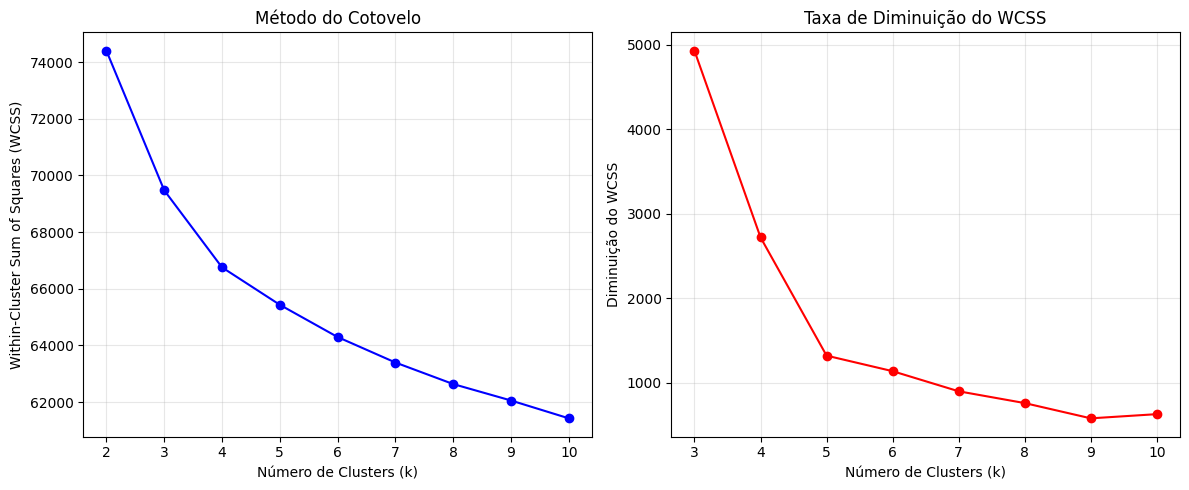


Ponto do cotovelo sugerido: 9 clusters


In [134]:
def find_optimal_clusters_elbow(embeddings, max_clusters=10):
    """Encontra número ótimo de clusters usando método do cotovelo"""
    wcss = []
    cluster_range = range(2, max_clusters + 1)
    
    print("Calculando WCSS para diferentes números de clusters...")
    for k in cluster_range:
        kmeans = KMeans(
            n_clusters=k, 
            random_state=42, 
            n_init=10,
            max_iter=300
        )
        kmeans.fit(embeddings)
        wcss.append(kmeans.inertia_)
        print(f"K={k}, WCSS={kmeans.inertia_:.2f}")
    
    # Plotar curva do cotovelo
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(cluster_range, wcss, 'bo-')
    plt.title('Método do Cotovelo')
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.grid(True, alpha=0.3)
    
    # Calcular diferenças para sugerir cotovelo
    differences = np.diff(wcss)
    plt.subplot(1, 2, 2)
    plt.plot(cluster_range[1:], -differences, 'ro-')
    plt.title('Taxa de Diminuição do WCSS')
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('Diminuição do WCSS')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Sugerir ponto do cotovelo
    if len(differences) > 1:
        elbow_point = cluster_range[np.argmax(differences)] + 1
    else:
        elbow_point = 10  # valor padrão
    
    print(f"\nPonto do cotovelo sugerido: {elbow_point} clusters")
    return wcss, elbow_point

# Encontrar número ótimo de clusters
wcss_values, recommended_k = find_optimal_clusters_elbow(embeddings)

## 5. Aplicação do Clustering

In [135]:
# Aplicar K-means com número ótimo de clusters
print(f"Aplicando K-means com {recommended_k} clusters...")

kmeans = KMeans(
    n_clusters=recommended_k, 
    random_state=42, 
    n_init=20,
    max_iter=2000,
    init='k-means++'
)
cluster_labels = kmeans.fit_predict(embeddings)

print("Clustering concluído!")

# Análise da distribuição dos clusters
unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_distribution = dict(zip(unique, counts))
print(f"Distribuição dos clusters: {cluster_distribution}")

# Criar DataFrame para análise
df_results = pd.DataFrame({
    'termo': list(terms_dict.keys()),
    'descricao': list(terms_dict.values()),
    'cluster': cluster_labels
})

print(f"\nDataFrame criado com {len(df_results)} termos")

Aplicando K-means com 9 clusters...
Clustering concluído!
Distribuição dos clusters: {0: 348, 1: 488, 2: 339, 3: 194, 4: 232, 5: 418, 6: 237, 7: 273, 8: 340}

DataFrame criado com 2869 termos


## 6. Análise de Representantes dos Clusters

In [136]:
def find_cluster_representatives(embeddings, cluster_labels, terms_list, n_representatives=10):
    """Encontra termos mais representativos de cada cluster"""
    cluster_representatives = {}
    
    for cluster_id in set(cluster_labels):
        cluster_mask = cluster_labels == cluster_id
        cluster_embeddings = embeddings[cluster_mask]
        cluster_terms = [terms_list[i] for i, mask in enumerate(cluster_mask) if mask]
        
        # Calcular centróide do cluster
        centroid = np.mean(cluster_embeddings, axis=0)
        
        # Calcular distâncias ao centróide
        distances = []
        for i, embedding in enumerate(cluster_embeddings):
            distance = np.linalg.norm(embedding - centroid)
            distances.append((distance, cluster_terms[i]))
        
        # Ordenar por distância e pegar os mais próximos
        distances.sort(key=lambda x: x[0])
        representatives = [term for _, term in distances[:n_representatives]]
        cluster_representatives[cluster_id] = representatives
    
    return cluster_representatives

def print_cluster_analysis(df, cluster_representatives, n_show=15):
    """Imprime análise detalhada dos clusters"""
    print("\n" + "="*80)
    print("ANÁLISE DOS CLUSTERS - REPRESENTANTES")
    print("="*80)
    
    # Ordenar clusters por tamanho
    cluster_sizes = df['cluster'].value_counts().sort_values(ascending=False)
    
    for cluster_id in cluster_sizes.index:
        cluster_data = df[df['cluster'] == cluster_id]
        cluster_size = len(cluster_data)
        representatives = cluster_representatives[cluster_id]
        
        print(f"\nCluster {cluster_id} - Tamanho: {cluster_size} ({cluster_size/len(df)*100:.1f}%)")
        print("-" * 60)
        print("Termos mais representativos:")
        for i, term in enumerate(representatives, 1):
            print(f"  {i:2d}. {term}")
        
        # Mostrar algumas descrições se disponíveis
        sample_descriptions = cluster_data[cluster_data['descricao'] != cluster_data['termo']]['descricao'].head(3)
        if not sample_descriptions.empty:
            print("\nExemplos de descrições:")
            for i, desc in enumerate(sample_descriptions, 1):
                print(f"  {i}. {desc[:80]}{'...' if len(desc) > 80 else ''}")

# Encontrar representantes e analisar clusters
representatives = find_cluster_representatives(
    embeddings, cluster_labels, list(terms_dict.keys()), n_representatives=15
)

print_cluster_analysis(df_results, representatives)


ANÁLISE DOS CLUSTERS - REPRESENTANTES

Cluster 1 - Tamanho: 488 (17.0%)
------------------------------------------------------------
Termos mais representativos:
   1. zilucoplan
   2. peplómero
   3. auto-inflamação
   4. atibuclimab
   5. tixagevimab
   6. regdanvimab
   7. ASC09F
   8. variante de preocupação
   9. bamlanivimab
  10. casirivimab
  11. ensovibep
  12. etesevimab
  13. imdevimab
  14. boceprevir
  15. incapacidade temporárian f

Exemplos de descrições:
  1. Fàrmac antineoplàstic que bloca la tirosina-cinasa de Bruton i inhibeix la repli...
  2. Àcid nucleic constituït per nucleòtids de desoxiribosa, àcid fosfòric i les base...
  3. Àcid nucleic constituït per nucleòtids de ribosa, àcid fosfòric i les bases nitr...

Cluster 5 - Tamanho: 418 (14.6%)
------------------------------------------------------------
Termos mais representativos:
   1. infarto medular
   2. holter
   3. leucaférese
   4. amiloidose sistêmica senil
   5. imunohemoterapia
   6. eletromiografia
  

## 7. Visualização dos Clusters

Aplicando redução de dimensionalidade...
PCA - Variância explicada: 0.232


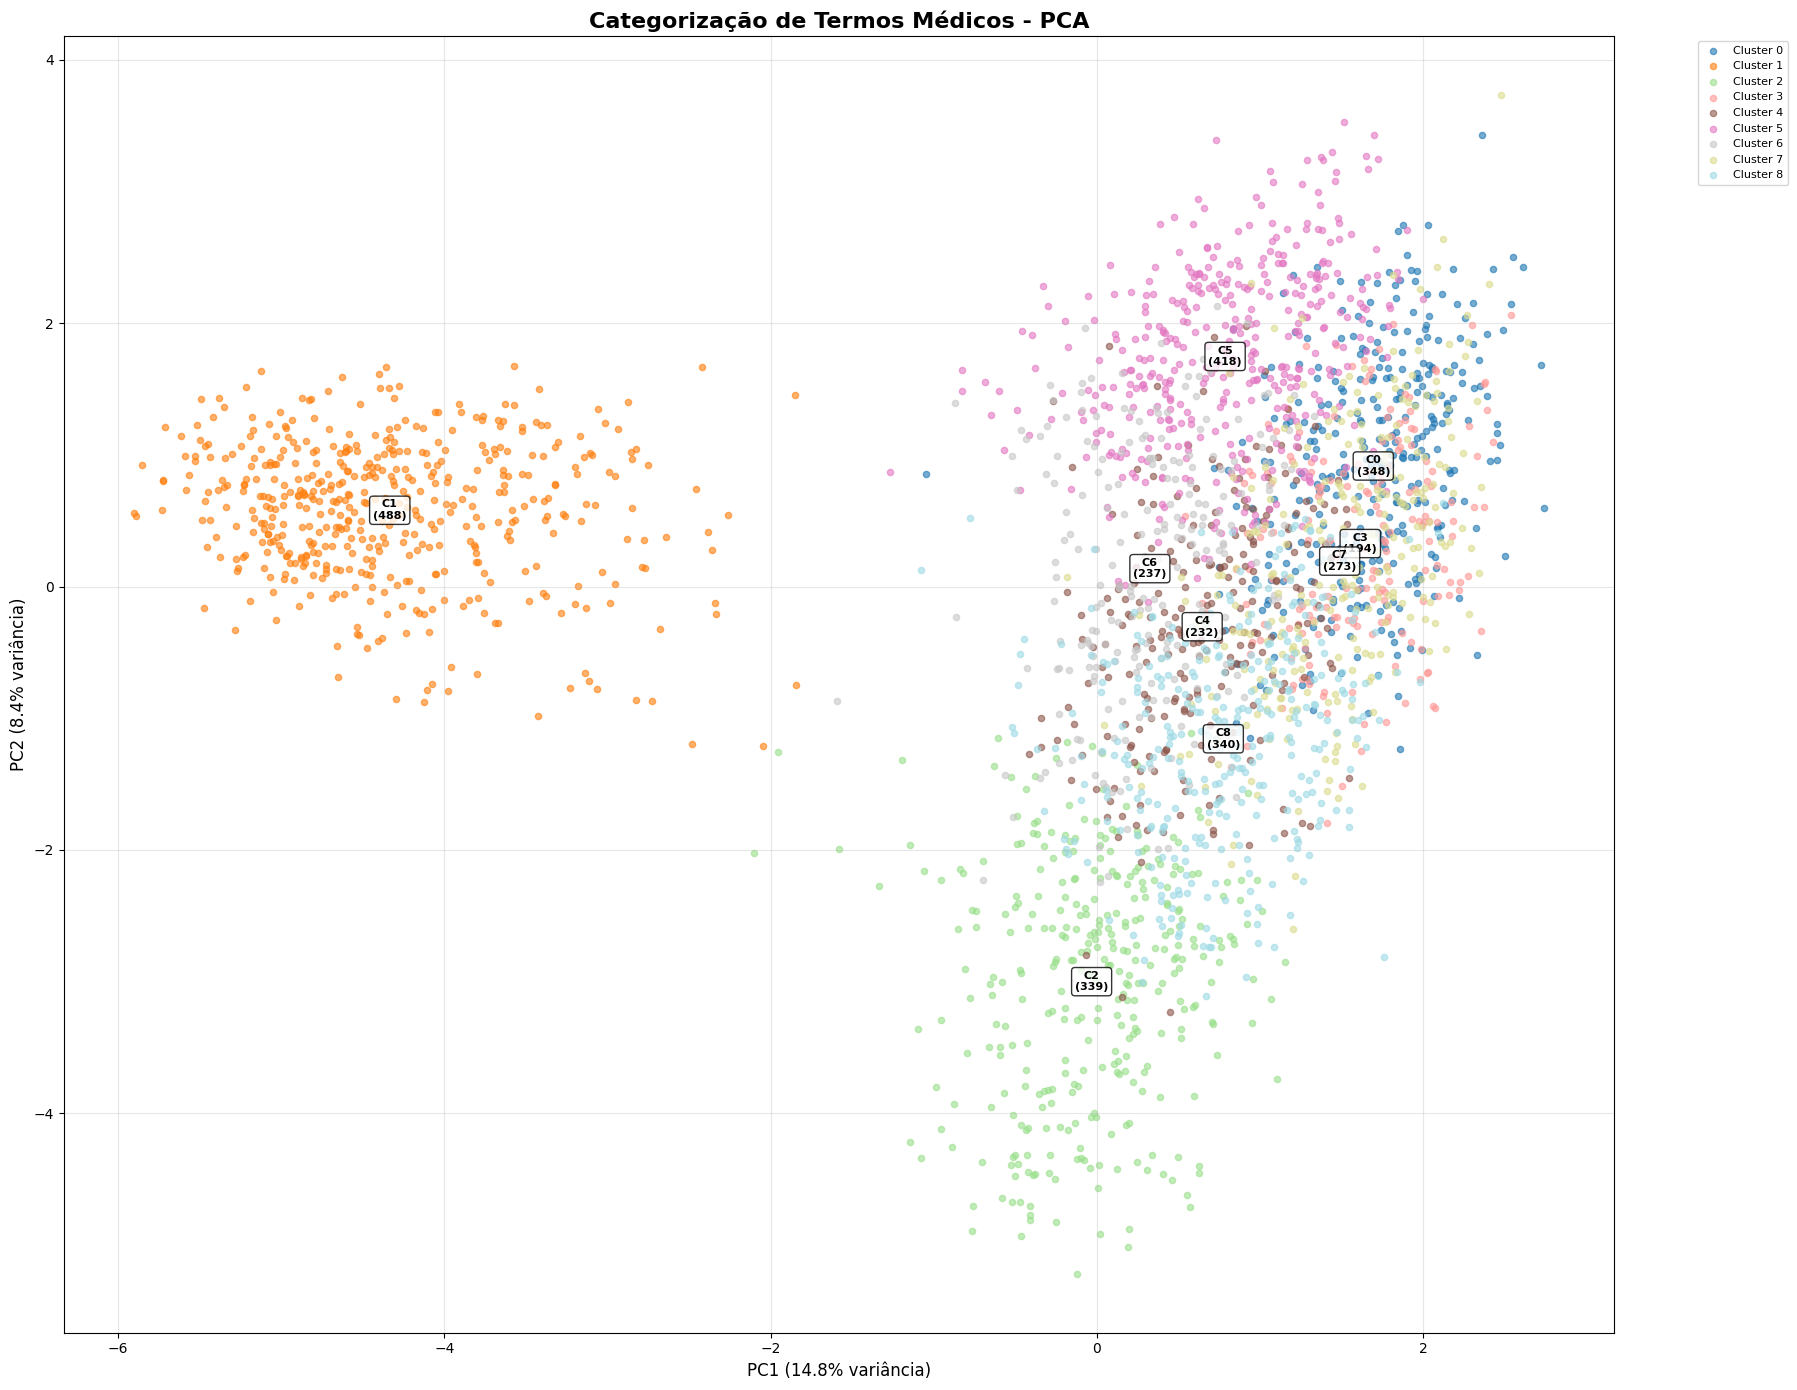

In [137]:
# Redução de dimensionalidade para visualização
print("Aplicando redução de dimensionalidade...")

# PCA
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(embeddings)
print(f"PCA - Variância explicada: {pca.explained_variance_ratio_.sum():.3f}")

# Criar visualização dos clusters
plt.figure(figsize=(18, 14))

n_clusters = len(set(cluster_labels))
colors = plt.cm.tab20(np.linspace(0, 1, n_clusters))

# Plot dos clusters
for i, cluster_id in enumerate(set(cluster_labels)):
    mask = cluster_labels == cluster_id
    plt.scatter(
        embeddings_2d[mask, 0], 
        embeddings_2d[mask, 1], 
        c=[colors[i]], 
        label=f"Cluster {cluster_id}",
        alpha=0.6,
        s=20
    )

# Adicionar labels dos centróides
cluster_results = defaultdict(list)
terms_list = list(terms_dict.keys())
for i, label in enumerate(cluster_labels):
    cluster_results[label].append(terms_list[i])

for cluster_id in cluster_results.keys():
    mask = cluster_labels == cluster_id
    center_x = embeddings_2d[mask, 0].mean()
    center_y = embeddings_2d[mask, 1].mean()
    cluster_size = sum(mask)
    
    plt.annotate(f'C{cluster_id}\n({cluster_size})', 
                (center_x, center_y), 
                fontsize=8, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                ha='center', va='center')

plt.title('Categorização de Termos Médicos - PCA', fontsize=16, fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variância)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variância)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

Gerando visualização t-SNE...


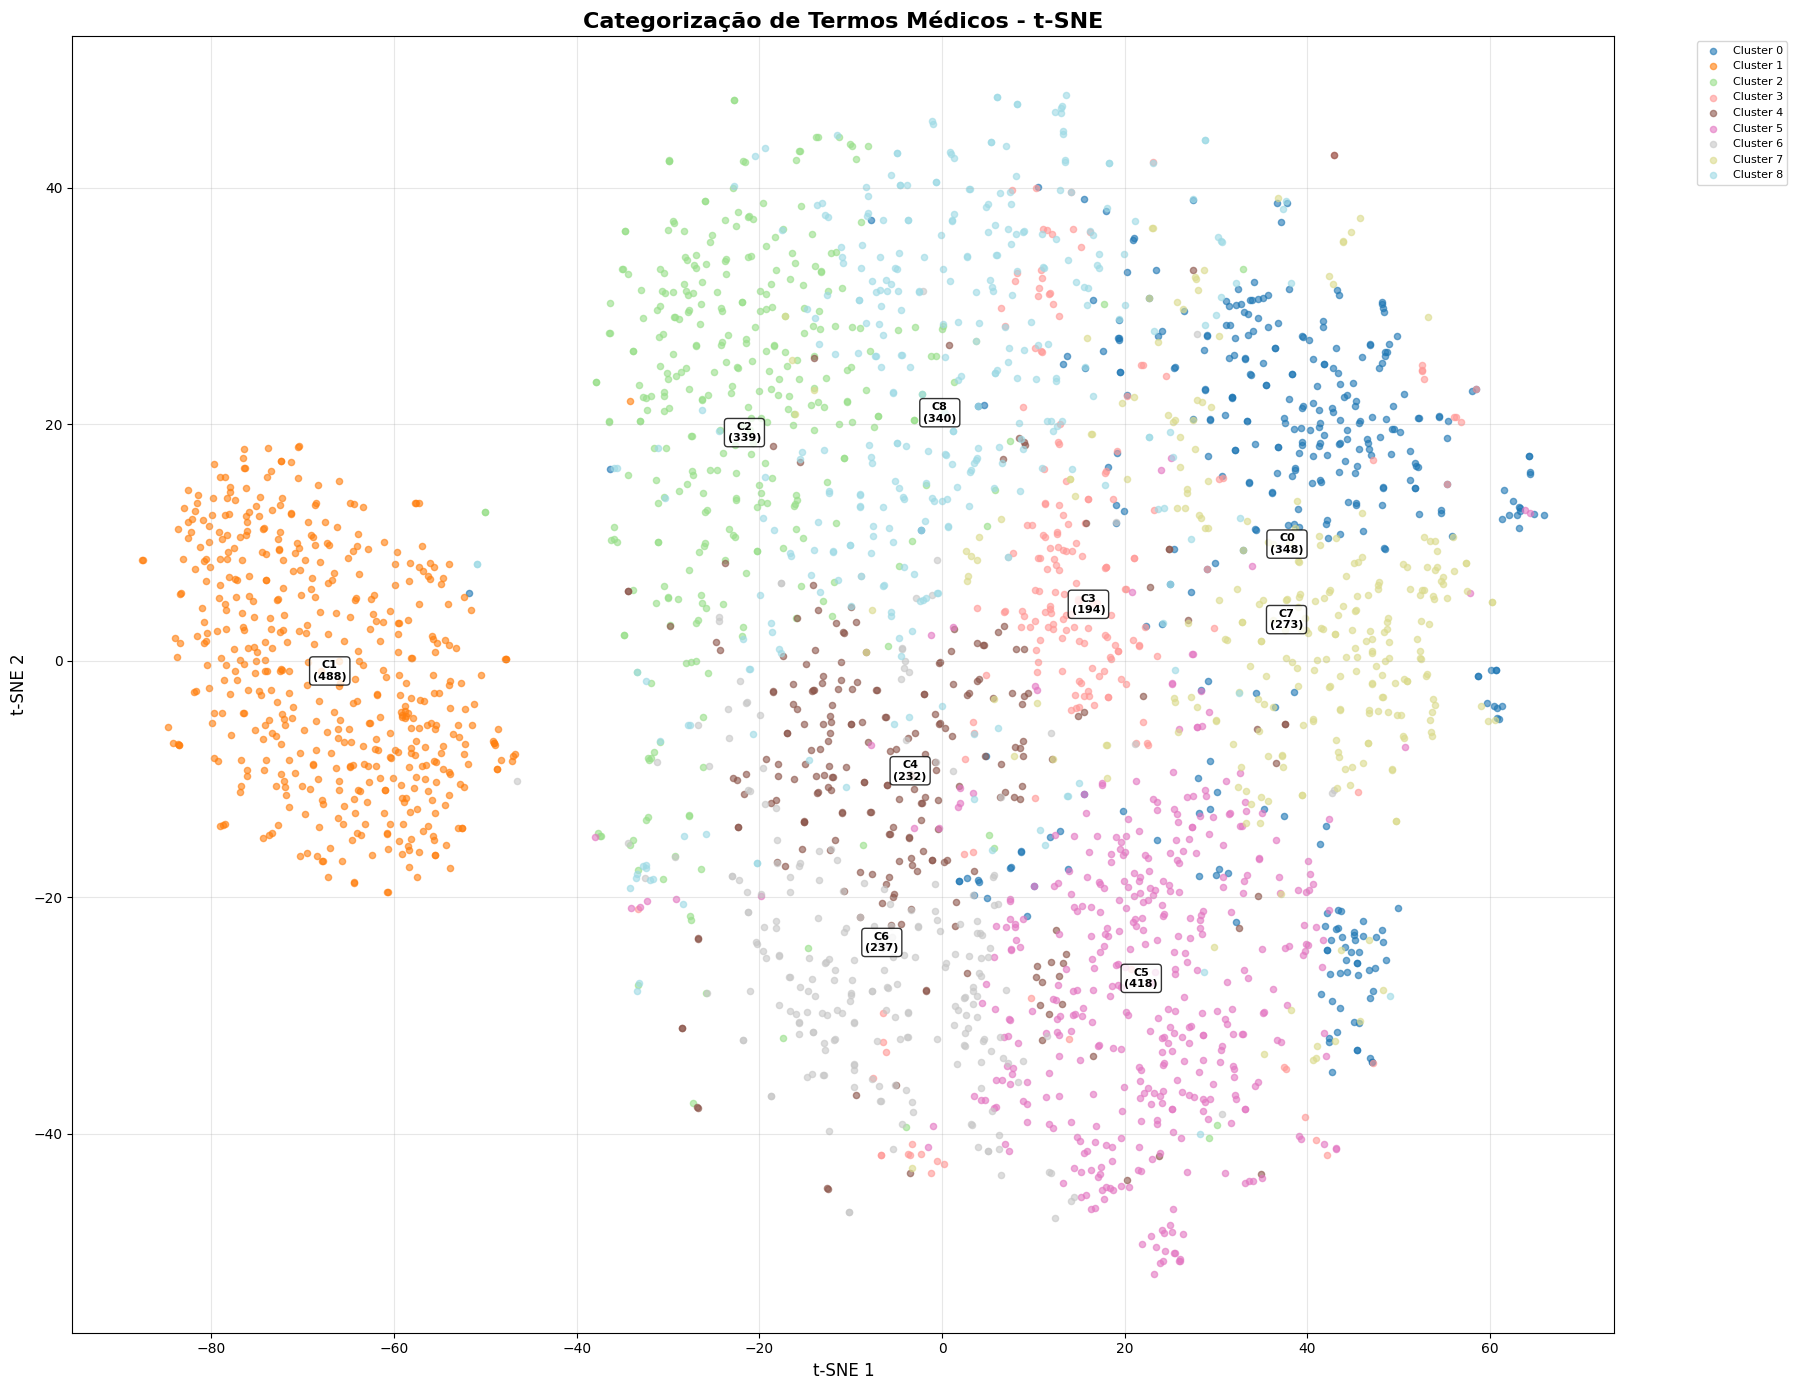

In [138]:
# Visualização adicional com t-SNE
print("Gerando visualização t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_tsne = tsne.fit_transform(embeddings)

plt.figure(figsize=(18, 14))

# Plot t-SNE
for i, cluster_id in enumerate(set(cluster_labels)):
    mask = cluster_labels == cluster_id
    plt.scatter(
        embeddings_tsne[mask, 0], 
        embeddings_tsne[mask, 1], 
        c=[colors[i]], 
        label=f"Cluster {cluster_id}",
        alpha=0.6,
        s=20
    )

# Adicionar labels dos centróides
for cluster_id in cluster_results.keys():
    mask = cluster_labels == cluster_id
    center_x = embeddings_tsne[mask, 0].mean()
    center_y = embeddings_tsne[mask, 1].mean()
    cluster_size = sum(mask)
    
    plt.annotate(f'C{cluster_id}\n({cluster_size})', 
                (center_x, center_y), 
                fontsize=8, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                ha='center', va='center')

plt.title('Categorização de Termos Médicos - t-SNE', fontsize=16, fontweight='bold')
plt.xlabel('t-SNE 1', fontsize=12)
plt.ylabel('t-SNE 2', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

## 8. Análise Quantitativa dos Clusters

In [149]:
# Criar DataFrame de análise dos clusters
def create_cluster_analysis_df(df, representatives):
    """Cria DataFrame com análise dos clusters"""
    analysis_data = []
    
    cluster_sizes = df['cluster'].value_counts()
    
    for cluster_id in sorted(cluster_sizes.index):
        cluster_data = df[df['cluster'] == cluster_id]
        cluster_size = len(cluster_data)
        representative_terms = ', '.join(representatives[cluster_id][:5])  # Top 5
        
        # Contar termos com descrição própria vs apenas termo
        terms_with_desc = len(cluster_data[cluster_data['descricao'] != cluster_data['termo']])
        terms_only = cluster_size - terms_with_desc
        
        analysis_data.append({
            'Cluster_ID': cluster_id,
            'Tamanho': cluster_size,
            'Percentual': f"{cluster_size/len(df)*100:.1f}%",
            'Com_Descricao': terms_with_desc,
            'Apenas_Termo': terms_only,
            'Representantes_Top5': representative_terms,
            'Todos_Termos': cluster_data['termo'].tolist()
        })
    
    return pd.DataFrame(analysis_data), analysis_data

# Criar análise
analysis_df, analysis_data = create_cluster_analysis_df(df_results, representatives)

analysis_df.to_csv('cluster_analysis.csv', index=False)

# Mostrar resumo
print("RESUMO QUANTITATIVO DOS CLUSTERS")
print("="*60)
print(analysis_df[['Cluster_ID', 'Tamanho', 'Percentual', 'Com_Descricao', 'Apenas_Termo']].to_string(index=False))

print(f"\nEstatísticas Gerais:")
print(f"Total de termos: {len(df_results)}")
print(f"Número de clusters: {len(analysis_df)}")
print(f"Cluster médio: {len(df_results)/len(analysis_df):.1f} termos")
print(f"Maior cluster: {analysis_df['Tamanho'].max()} termos")
print(f"Menor cluster: {analysis_df['Tamanho'].min()} termos")

RESUMO QUANTITATIVO DOS CLUSTERS
 Cluster_ID  Tamanho Percentual  Com_Descricao  Apenas_Termo
          0      348      12.1%            347             1
          1      488      17.0%            488             0
          2      339      11.8%            290            49
          3      194       6.8%            192             2
          4      232       8.1%            231             1
          5      418      14.6%            418             0
          6      237       8.3%            232             5
          7      273       9.5%            271             2
          8      340      11.9%            324            16

Estatísticas Gerais:
Total de termos: 2869
Número de clusters: 9
Cluster médio: 318.8 termos
Maior cluster: 488 termos
Menor cluster: 194 termos


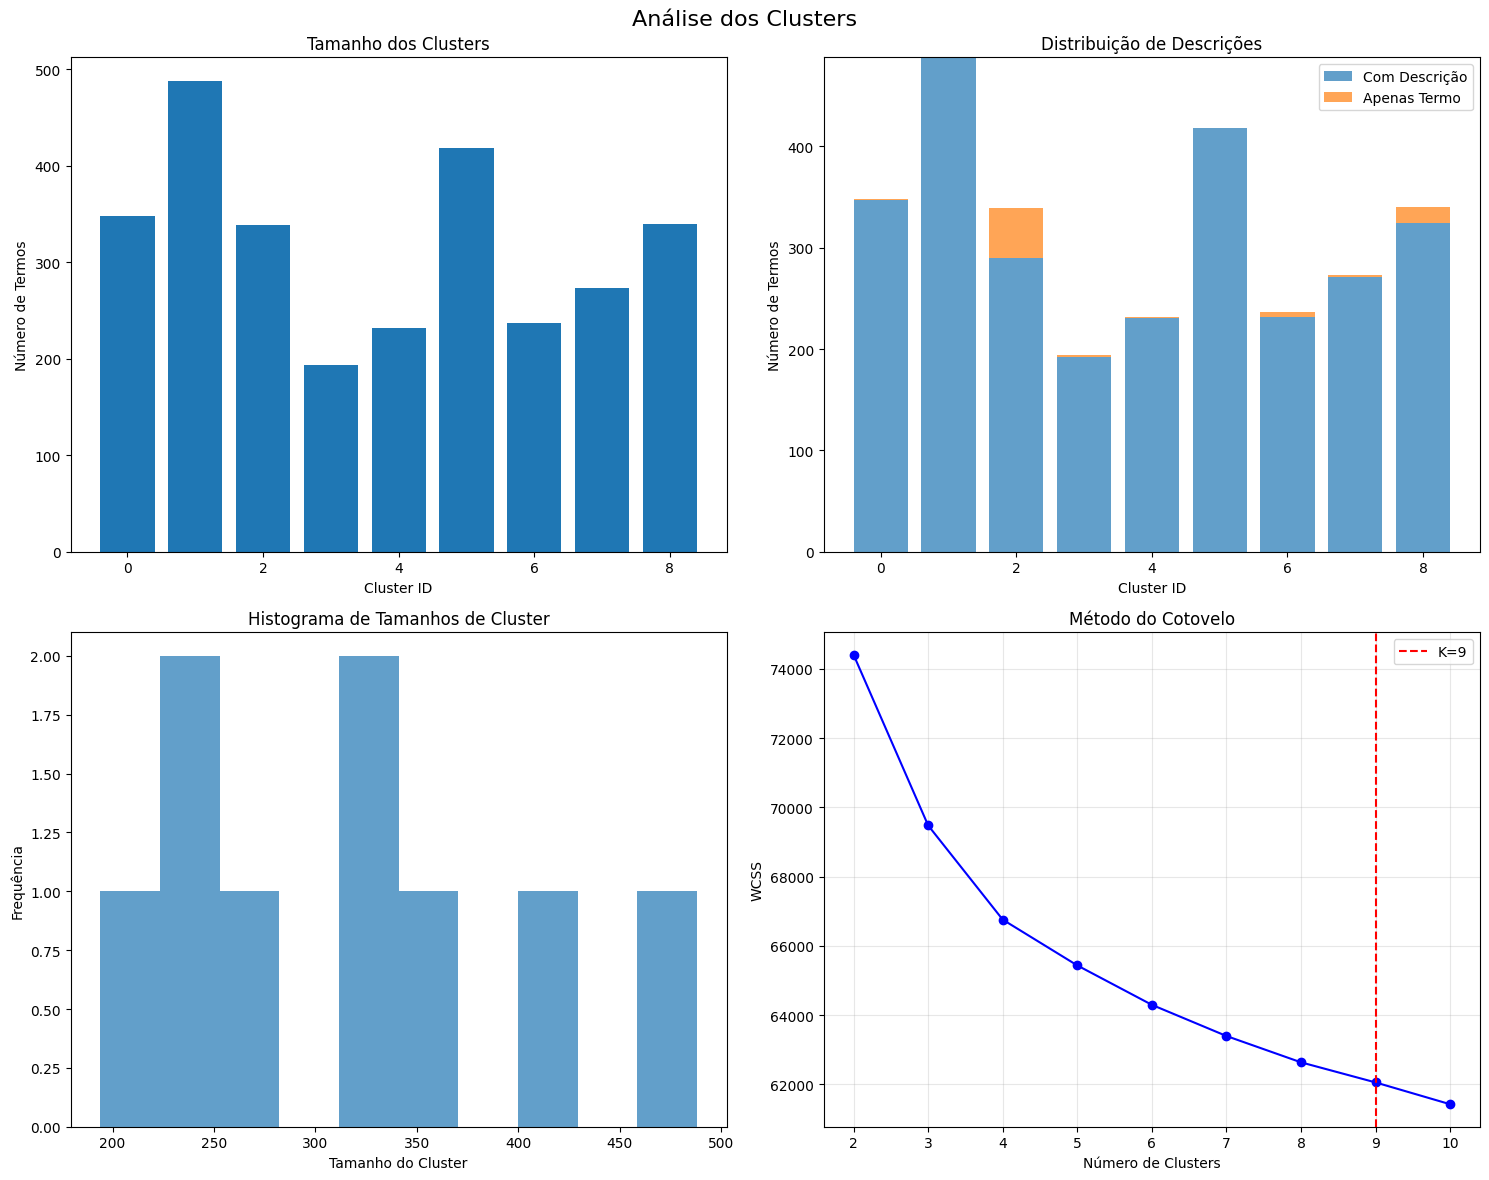

In [140]:
# Visualizar distribuições
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Análise dos Clusters', fontsize=16)

# Distribuição de tamanhos
axes[0,0].bar(analysis_df['Cluster_ID'], analysis_df['Tamanho'])
axes[0,0].set_title('Tamanho dos Clusters')
axes[0,0].set_xlabel('Cluster ID')
axes[0,0].set_ylabel('Número de Termos')

# Distribuição de termos com/sem descrição
axes[0,1].bar(analysis_df['Cluster_ID'], analysis_df['Com_Descricao'], label='Com Descrição', alpha=0.7)
axes[0,1].bar(analysis_df['Cluster_ID'], analysis_df['Apenas_Termo'], 
              bottom=analysis_df['Com_Descricao'], label='Apenas Termo', alpha=0.7)
axes[0,1].set_title('Distribuição de Descrições')
axes[0,1].set_xlabel('Cluster ID')
axes[0,1].set_ylabel('Número de Termos')
axes[0,1].legend()

# Histograma de tamanhos de cluster
axes[1,0].hist(analysis_df['Tamanho'], bins=10, alpha=0.7)
axes[1,0].set_title('Histograma de Tamanhos de Cluster')
axes[1,0].set_xlabel('Tamanho do Cluster')
axes[1,0].set_ylabel('Frequência')

# Curva do cotovelo
axes[1,1].plot(range(2, len(wcss_values) + 2), wcss_values, 'bo-')
axes[1,1].axvline(x=recommended_k, color='r', linestyle='--', label=f'K={recommended_k}')
axes[1,1].set_title('Método do Cotovelo')
axes[1,1].set_xlabel('Número de Clusters')
axes[1,1].set_ylabel('WCSS')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Exportar Resultados

In [144]:
# Converter numpy types para tipos Python nativos para JSON
def convert_numpy_types(obj):
    """Converte tipos numpy para tipos Python nativos"""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {str(k): convert_numpy_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    else:
        return obj

# Preparar dados para JSON com conversão de tipos
representatives_json = {}
for k, v in representatives.items():
    representatives_json[str(k)] = v  # Converter chave para string


# Resumo final
print("\n" + "="*60)
print("RESUMO FINAL DO CLUSTERING")
print("="*60)
print(f"Modelo BERT: {model_name}")
print(f"Total de termos: {len(terms_dict)}")
print(f"Dimensão dos embeddings: {embeddings.shape[1]}")
print(f"Número de clusters: {recommended_k}")
print(f"WCSS final: {wcss_values[recommended_k-2]:.2f}")
print(f"Variância explicada (PCA): {pca.explained_variance_ratio_.sum():.3f}")


RESUMO FINAL DO CLUSTERING
Modelo BERT: neuralmind/bert-base-portuguese-cased
Total de termos: 2869
Dimensão dos embeddings: 768
Número de clusters: 9
WCSS final: 62053.55
Variância explicada (PCA): 0.232


## 10. Nomeação e Categorização dos Clusters

In [142]:
def suggest_cluster_names(representatives, cluster_sizes):
    """Sugere nomes descritivos para cada cluster baseado nos termos representativos"""
    
    cluster_names = {
        0: "Processos Inflamatórios e Cirúrgicos",
        1: "Farmacologia Molecular COVID-19", 
        2: "Fisiologia e Processos Corporais",
        3: "Distúrbios Metabólicos e Sanguíneos",
        4: "Bioquímica e Investigação Clínica",
        5: "Tecnologia Médica e Doenças Complexas",
        6: "Farmacologia Natural e Sintética",
        7: "Anatomia e Localizações Corporais",
        8: "Sintomas e Manifestações Clínicas"
    }
    
    # Categorias principais
    main_categories = {
        "Farmacologia e Medicamentos": [1, 6],
        "Doenças e Patologias": [0, 3, 5],
        "Anatomia e Fisiologia": [2, 7, 8],
        "Ciências Básicas": [4]
    }
    
    return cluster_names, main_categories

# Obter nomes dos clusters
cluster_names, main_categories = suggest_cluster_names(representatives, df_results['cluster'].value_counts())

print("NOMES SUGERIDOS PARA OS CLUSTERS")
print("=" * 60)
print()

# Mostrar clusters organizados por categoria
for category, cluster_ids in main_categories.items():
    print(f"{category.upper()}")
    print("-" * 40)
    for cluster_id in cluster_ids:
        cluster_size = len(df_results[df_results['cluster'] == cluster_id])
        percentage = (cluster_size / len(df_results)) * 100
        print(f"  Cluster {cluster_id:2d}: {cluster_names[cluster_id]}")
        print(f"              Tamanho: {cluster_size} termos ({percentage:.1f}%)")
        print(f"              Representantes: {', '.join(representatives[cluster_id][:3])}")
    print()

# Criar DataFrame com nomes dos clusters
df_named_clusters = df_results.copy()
df_named_clusters['cluster_name'] = df_named_clusters['cluster'].map(cluster_names)

# Estatísticas por categoria
print("ESTATÍSTICAS POR CATEGORIA PRINCIPAL")
print("=" * 50)
category_stats = []
for category, cluster_ids in main_categories.items():
    category_terms = df_named_clusters[df_named_clusters['cluster'].isin(cluster_ids)]
    total_terms = len(category_terms)
    percentage = (total_terms / len(df_results)) * 100
    n_clusters = len(cluster_ids)
    
    category_stats.append({
        'Categoria': category,
        'Clusters': n_clusters,
        'Termos': total_terms,
        'Percentual': f"{percentage:.1f}%"
    })
    
    print(f"{category:30s}: {total_terms:3d} termos ({percentage:4.1f}%) em {n_clusters} clusters")

print()

# Análise dos clusters por ordem de tamanho
print("CLUSTERS ORDENADOS POR TAMANHO")
print("=" * 40)
top_clusters = df_results['cluster'].value_counts()
for rank, (cluster_id, size) in enumerate(top_clusters.items(), 1):
    percentage = (size / len(df_results)) * 100
    name = cluster_names.get(cluster_id, f"Cluster {cluster_id}")
    print(f"{rank:2d}. {name}")
    print(f"    {size} termos ({percentage:.1f}%) - Representantes: {', '.join(representatives[cluster_id][:3])}")

NOMES SUGERIDOS PARA OS CLUSTERS

FARMACOLOGIA E MEDICAMENTOS
----------------------------------------
  Cluster  1: Farmacologia Molecular COVID-19
              Tamanho: 488 termos (17.0%)
              Representantes: zilucoplan, peplómero, auto-inflamação
  Cluster  6: Farmacologia Natural e Sintética
              Tamanho: 237 termos (8.3%)
              Representantes: anafiláctico, shitake, adjuvante genético

DOENÇAS E PATOLOGIAS
----------------------------------------
  Cluster  0: Processos Inflamatórios e Cirúrgicos
              Tamanho: 348 termos (12.1%)
              Representantes: sintomatologia, mastoidite, traqueíte
  Cluster  3: Distúrbios Metabólicos e Sanguíneos
              Tamanho: 194 termos (6.8%)
              Representantes: hiperostose, hipervolemia, oncolítico
  Cluster  5: Tecnologia Médica e Doenças Complexas
              Tamanho: 418 termos (14.6%)
              Representantes: infarto medular, holter, leucaférese

ANATOMIA E FISIOLOGIA
-------------

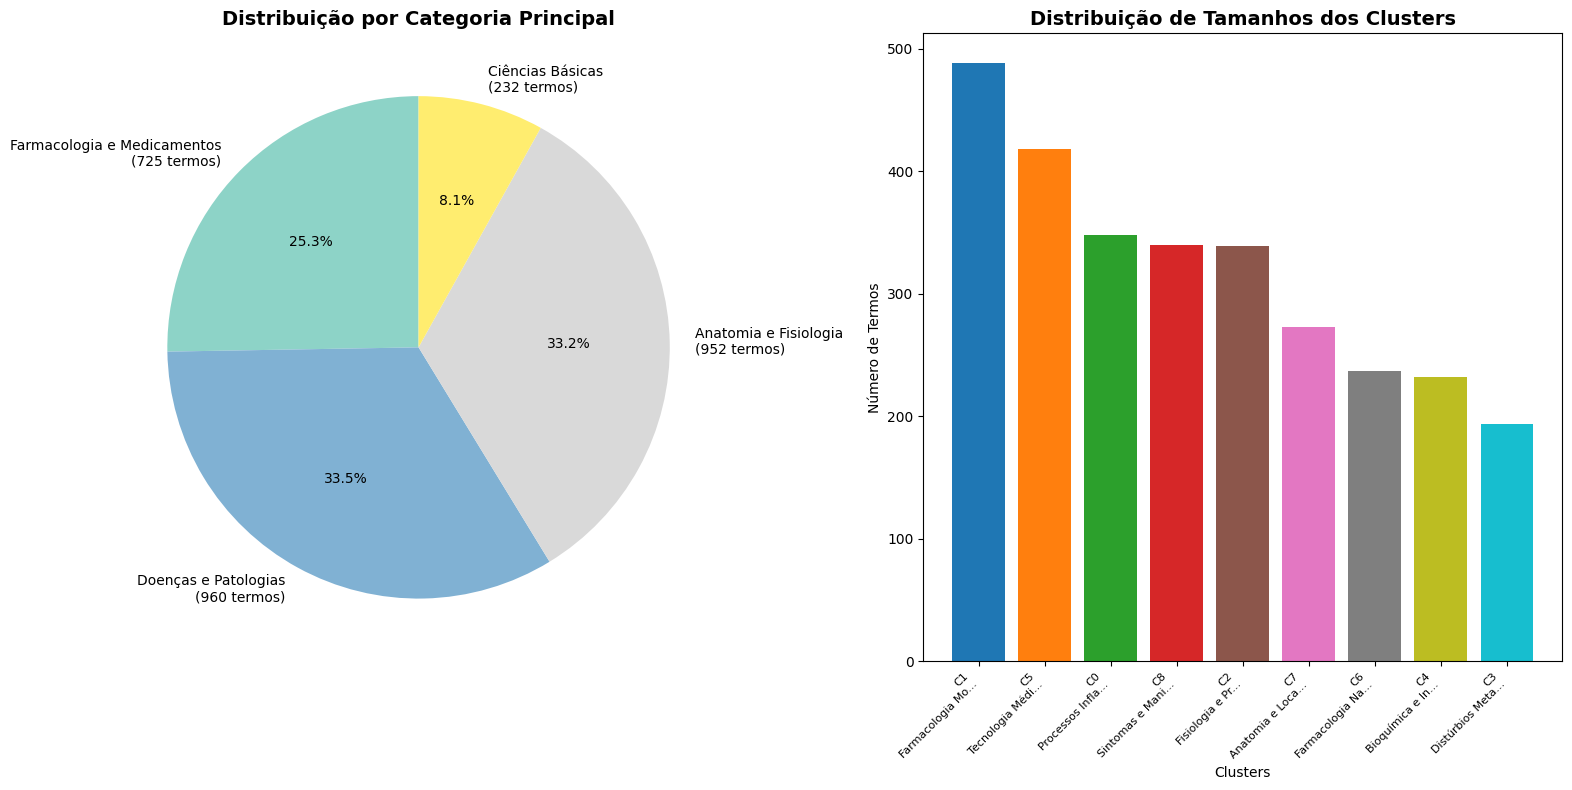

In [143]:
# Visualização das categorias principais
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Gráfico de pizza das categorias principais
category_data = []
category_labels = []
for category, cluster_ids in main_categories.items():
    category_terms = df_named_clusters[df_named_clusters['cluster'].isin(cluster_ids)]
    total_terms = len(category_terms)
    category_data.append(total_terms)
    category_labels.append(f"{category}\n({total_terms} termos)")

colors = plt.cm.Set3(np.linspace(0, 1, len(category_data)))
wedges, texts, autotexts = ax1.pie(category_data, labels=category_labels, autopct='%1.1f%%', 
                                   colors=colors, startangle=90)
ax1.set_title('Distribuição por Categoria Principal', fontsize=14, fontweight='bold')

# Gráfico de barras dos clusters individuais
all_clusters = df_results['cluster'].value_counts()
cluster_labels_viz = [f"C{i}\n{cluster_names.get(i, f'Cluster {i}')[:15]}..." 
                     for i in all_clusters.index]
ax2.bar(range(len(all_clusters)), all_clusters.values, 
        color=plt.cm.tab10(np.linspace(0, 1, len(all_clusters))))
ax2.set_xlabel('Clusters')
ax2.set_ylabel('Número de Termos')
ax2.set_title('Distribuição de Tamanhos dos Clusters', fontsize=14, fontweight='bold')
ax2.set_xticks(range(len(all_clusters)))
ax2.set_xticklabels(cluster_labels_viz, rotation=45, ha='right', fontsize=8)

plt.tight_layout()
plt.show()

In [153]:
cluster_names = {
        0: "Processos Inflamatórios e Cirúrgicos",
        1: "Farmacologia Molecular COVID-19", 
        2: "Fisiologia e Processos Corporais",
        3: "Distúrbios Metabólicos e Sanguíneos",
        4: "Bioquímica e Investigação Clínica",
        5: "Tecnologia Médica e Doenças Complexas",
        6: "Farmacologia Natural e Sintética",
        7: "Anatomia e Localizações Corporais",
        8: "Sintomas e Manifestações Clínicas"
    }

with open('final_with_predicted_fields.json', 'r', encoding='utf-8') as f:
    original_data = json.load(f)

for cluster in analysis_data:
    cluster_id = cluster['Cluster_ID']
    terms = cluster['Todos_Termos']
    for term in terms:
        if term in original_data:
            original_data[term]['cluster'] = cluster_names[cluster_id]

with open('final_final.json', 'w', encoding='utf-8') as f:
    json.dump(original_data, f, ensure_ascii=False, indent=4)